<a href="https://colab.research.google.com/github/standard-aaron/deep-learning-projects/blob/main/pyro_markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 16.5 MB/s 


In [2]:
import numpy as np
import torch
from torch import nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt

# Overview

In this notebook I'm working through a basic example of a inferring the latent state of a Gaussian HMM via SVI + amortized inference.

$Z$ is the latent state; $Z_{t+1} \mid Z_t \sim N(Z_t, \sigma_z)$

$Y$ is the noisy observation of Z; $Y_{t} \mid Z_t \sim N(Z_t, \sigma_y)$

In [66]:
T = 100 # The number of observations per row, all with shared $\sigma_z, \sigma_y$
N = 1000 # The number of rows, each with a unique $\sigma_z, \sigma_y$
BUFFER = 20

def simulate_data(n=N):
  sigma_z = 1.0 + np.random.chisquare(df=1, size=N)
  sigma_y = (1.0 + np.random.chisquare(df=1, size=N))*sigma_z
  Z = []
  Y = []
  z = np.zeros(N)
  for t in range(T + BUFFER):
    z = np.random.normal(z, scale=sigma_z)
    Z.append(z)
    y = np.random.normal(z, scale=sigma_y)
    Y.append(y)
  Z = torch.tensor(np.vstack(Z).T, dtype=torch.float32)
  Y = torch.tensor(np.vstack(Y).T, dtype=torch.float32)
  return Z, Y, sigma_z, sigma_y
  
Z, Y, sigma_z, sigma_y = simulate_data()

In order to perform amortized inference, we need to specify an encoding module $g(x)$ that
maps from (potentially new, unseen) input data $x_i$ to predicted variational
parameters $\phi$.
The reason amortized inference is good is e.g. so that we don't have to
re-train the model
when new data arrives;
instead, we just *predict* the optimal variational parameters using
$g(x_i) = \hat{\phi^*}$.

In this example, our encoder $g(x)$ is a simple MLP with 1 hidden layer.

In [98]:
class Encoder(nn.Module):
  EPS = 1e-3

  def __init__(self, hidden_dim=64, buffer=BUFFER):
      super().__init__()
      # setup the three linear transformations used
      self.fc1 = nn.Linear(buffer-1, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, hidden_dim)
      self.fc3a = nn.Linear(hidden_dim, 1)
      self.fc3b = nn.Linear(hidden_dim, 1)
      # setup the non-linearities
      self.softplus = nn.Softplus()

  def forward(self, x):
      hidden = self.softplus(self.fc1(x))
      hidden = self.softplus(self.fc2(hidden))
      mu = self.fc3a(hidden)
      sigma = self.softplus(self.fc3b(hidden)) + self.EPS
      return mu, sigma

class MyVariationalModule(nn.Module):
  def __init__(self, buffer=BUFFER):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(buffer=BUFFER)
        self.buffer = BUFFER

  def model(self, data):
    num_sequences = data.shape[0]
    length = data.shape[1] - self.buffer
    z = torch.ones(num_sequences)
    with pyro.plate("data", dim=-2):
      sigma_z = pyro.param("sigma_z", torch.ones(num_sequences), constraint=constraints.positive)
      sigma_y = pyro.param("sigma_y", torch.ones(num_sequences), constraint=constraints.positive)
      for t in pyro.markov(range(length)):
        z = pyro.sample(f"z_{t+1}", dist.Normal(z, sigma_z))
        pyro.sample(f"y_{t+1}", dist.Normal(z, sigma_y), obs=data[:, t+self.buffer])

  # define the guide (i.e. variational distribution) q(z|x)
  def guide(self, data):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    # use the encoder to get the parameters used to define q(z|x)
    num_sequences = data.shape[0]
    length = data.shape[1]
    with pyro.plate("data", dim=-2):
      for t in range(self.buffer, length):
        mu, sigma = self.encoder(data[:, (t-self.buffer):(t-1)])
        pyro.sample(f"z_{t+1-self.buffer}", dist.Normal(mu[:, 0], sigma[:, 0]))

In [108]:
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 1e-2, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

v = MyVariationalModule()

# setup the inference algorithm
svi = SVI(v.model, v.guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
# do gradient steps
for step in range(n_steps):
  loss = svi.step(Y)
  if step % 10 == 0: 
    print(step, loss)

0 24033861.009399414
10 4459995.098876953
20 3041588.796356201
30 2645746.9766750336
40 2225244.90423584
50 1912161.4502563477
60 1652939.4478759766
70 1488415.787902832
80 1338865.6013183594
90 1237659.3311767578
100 1158401.7180175781
110 1095248.8974609375
120 1034792.1429443359
130 981197.5699462891
140 937752.5059814453
150 898739.3521728516
160 864491.2464599609
170 833524.0367431641
180 805459.6628417969
190 780100.4385986328
200 757967.0263671875
210 736867.1951904297
220 719376.9772949219
230 699430.9874267578
240 682077.4002685547
250 668659.5512695312
260 653186.9945068359
270 640909.1928710938
280 627025.1352539062
290 615976.2717285156
300 605154.9536132812
310 593838.1638183594
320 584179.3295898438
330 574495.2277832031
340 567491.9837646484
350 559268.2746582031
360 550204.6872558594
370 544772.8986816406
380 537857.8109130859
390 530296.0505371094
400 523904.3288574219
410 518304.62548828125
420 510842.10485839844
430 507909.7744140625
440 502794.4270019531
450 497451.

KeyboardInterrupt: ignored

In [109]:
def get_params(Y, module):
  num_sequences, length = Y.shape
  mus = []
  sigmas = []
  for t in range(BUFFER, length):
    mu, sigma = module.encoder(Y[:, (t-BUFFER):(t-1)])
    mus.append(mu[:,0].detach().numpy())
    sigmas.append(sigma[:,0].detach().numpy())
  return np.array(mus).T, np.array(sigmas).T

In [110]:
# Predicted mean parameters on the training data
mu, sigma = get_params(Y, v)

Text(0.5, 1.0, 'Training set fit')

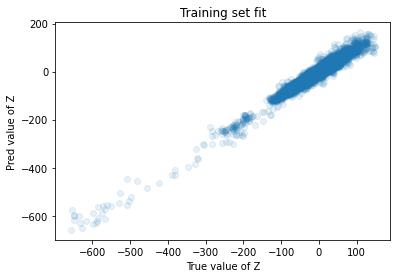

In [111]:
plt.scatter(mu.flatten(), Z[:, BUFFER:].flatten(), alpha=0.1)
plt.plot([-60, 100], [-60, 100])

plt.xlabel('True value of Z')
plt.ylabel("Pred value of Z")
plt.title("Training set fit")

Text(0.5, 1.0, 'Individual examples on training set')

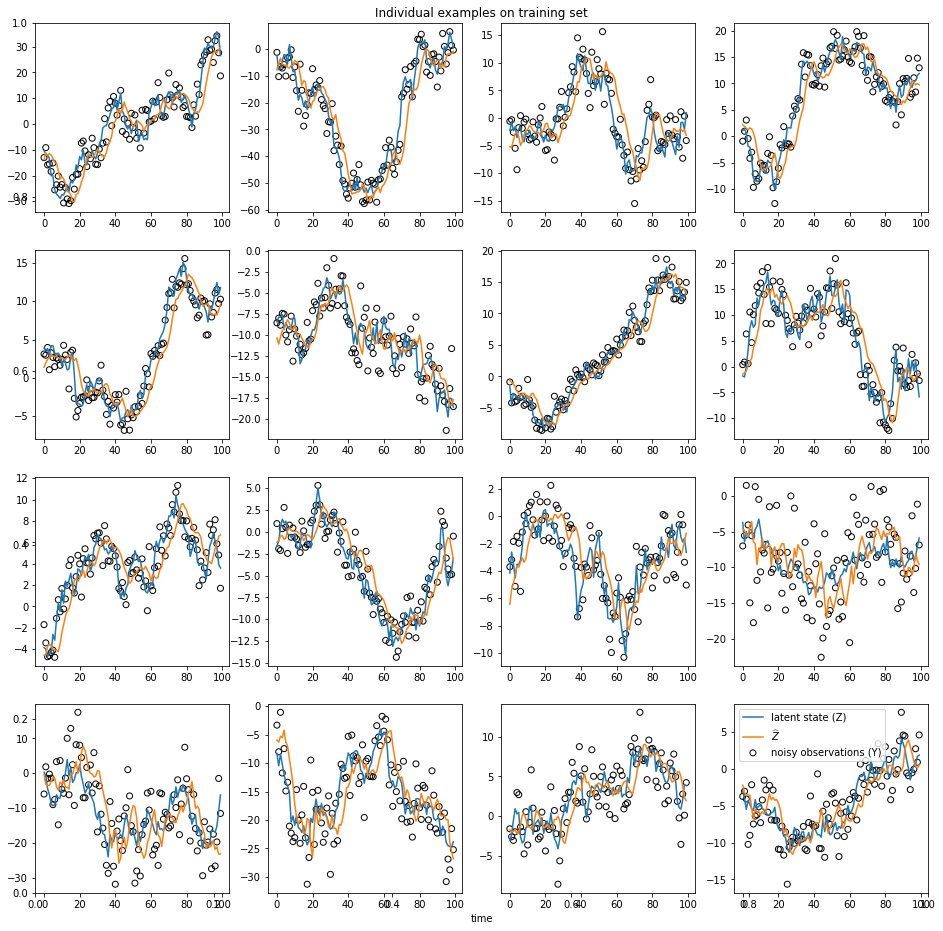

In [112]:
f, axes = plt.subplots(4, 4)
f.set_size_inches(16, 16)
for i in range(16):
  ax = axes[i//4][i%4]
  ax.scatter(
      np.arange(T),
      Y[i, BUFFER:],
      label='noisy observations (Y)',
      color='k',
      facecolor='none'
  )
  ax.plot(Z[i, BUFFER:], label='latent state (Z)')
  ax.plot(mu[i, :], label=r'$\widehat{Z}$')

ax.legend()
f.add_subplot(111, frameon=False)
plt.xlabel('time')
plt.title('Individual examples on training set')


Text(0.5, 1.0, 'Test set fit')

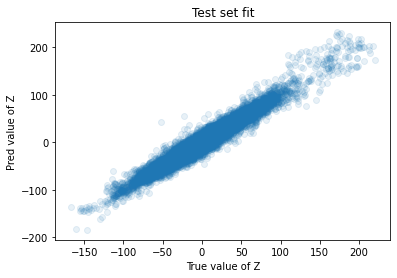

In [113]:
# Compare to holdout data estimates

Z_holdout, Y_holdout, _, _ = simulate_data()

with torch.no_grad():
  mu_holdout, sigma_holdout = mu, sigma = get_params(Y_holdout, v)

plt.scatter(mu_holdout.flatten(), Z_holdout[:, BUFFER:].flatten(), alpha=0.1)
plt.plot([-60, 100], [-60, 100])

plt.xlabel('True value of Z')
plt.ylabel("Pred value of Z")
plt.title("Test set fit")

Text(0.5, 1.0, 'Individual examples on holdout set')

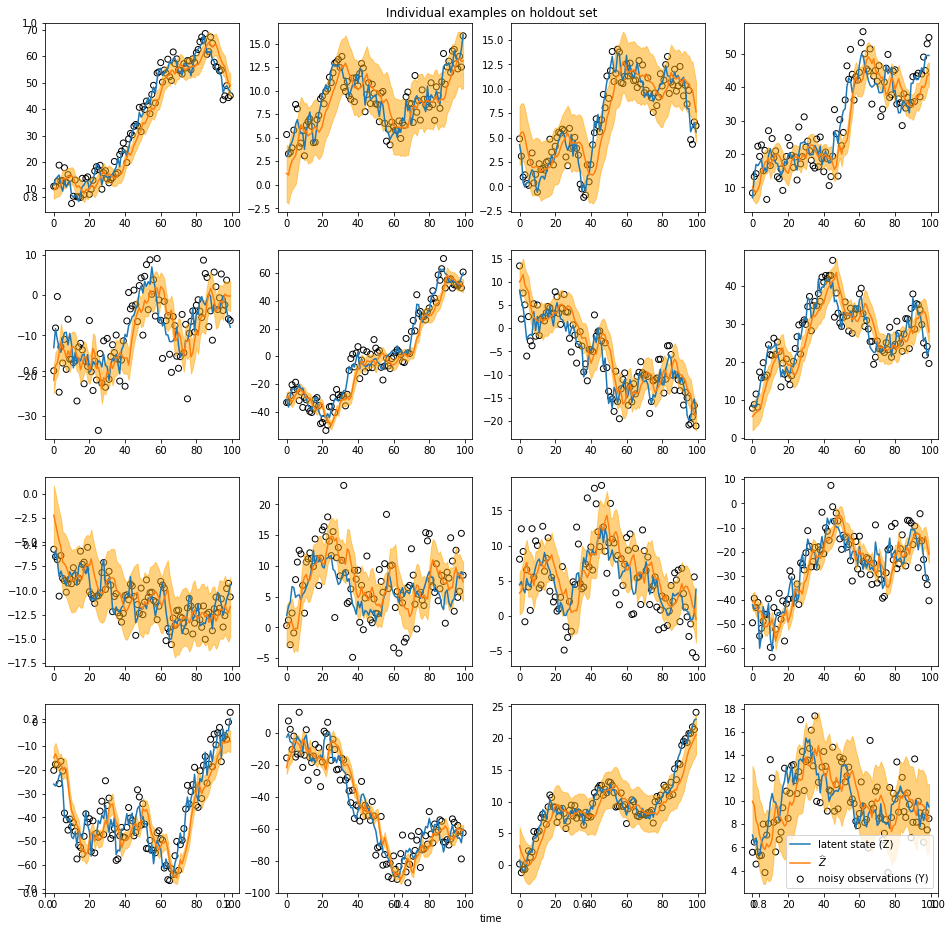

In [114]:
f, axes = plt.subplots(4, 4)
f.set_size_inches(16, 16)
for i in range(16):
  ax = axes[i//4][i%4]
  ax.scatter(
      np.arange(T),
      Y_holdout[i, BUFFER:],
      label='noisy observations (Y)',
      color='k',
      facecolor='none'
  )
  ax.plot(Z_holdout[i, BUFFER:], label='latent state (Z)')
  ax.plot(mu_holdout[i, :], label=r'$\widehat{Z}$')
  ax.fill_between(
      np.arange(T),
      mu_holdout[i, :] - 2*sigma_holdout[i, :],
      mu_holdout[i, :] + 2*sigma_holdout[i, :],
      color='orange', alpha=0.5
  )
ax.legend()
f.add_subplot(111, frameon=False)
plt.xlabel('time')
plt.title('Individual examples on holdout set')


Text(0.5, 0, 'Coefficient of determination (R^2)')

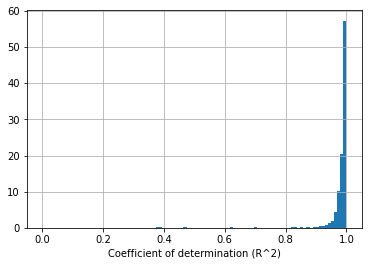

In [131]:
from scipy.stats import stats
R2 = [1 - np.mean(m - z.numpy())**2/np.cov(m, z)[1, 1] for m, z in zip(mu_holdout, Z_holdout[:, BUFFER:])]
plt.hist(R2, bins=np.linspace(0, 1, 100), density=True)
plt.grid()
plt.xlabel("Coefficient of determination (R^2)")